# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3952.599883,0.9999,-131.886217,1767.67,1635.783783
OMUSDT,526.319895,1782.730092,0.4510,0.000000,1256.41,1256.410000
BTCUSDT,601.021649,956.253141,0.2419,3.537078,355.23,358.767078
SOLUSDT,281.200518,461.021194,0.1166,0.000000,179.82,179.820000
JASMYUSDT,387.458505,365.749063,0.0925,0.000000,-21.71,-21.710000
ETHUSDT,250.747339,231.896809,0.0587,0.000000,-18.85,-18.850000
TRXUSDT,76.868953,116.444665,0.0295,-10.723889,39.58,28.856111
BBUSDT,60.176053,37.321750,0.0094,-39.733101,-22.85,-62.583101
BNBUSDT,1.142121,1.183166,0.0003,-10.606040,0.04,-10.566040
PEPEUSDT,0.000004,0.000004,0.0000,-38.521986,0.00,-38.521986


In [20]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [21]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [22]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [23]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [25]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [27]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [28]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\niroo\AppData\Local\Temp\ipykernel_12224\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [29]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-01-15    217.398651
2025-01-16    -59.599538
2025-01-17    124.747094
2025-01-18    -15.903539
2025-01-19   -199.344350
Name: Total, Length: 119, dtype: float64

In [30]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-01-15    1574.829706
2025-01-16    1515.230168
2025-01-17    1639.977262
2025-01-18    1624.073723
2025-01-19    1424.729372
Name: Total, Length: 119, dtype: float64

In [31]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [32]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [33]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [34]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_12224\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [35]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [36]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [37]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

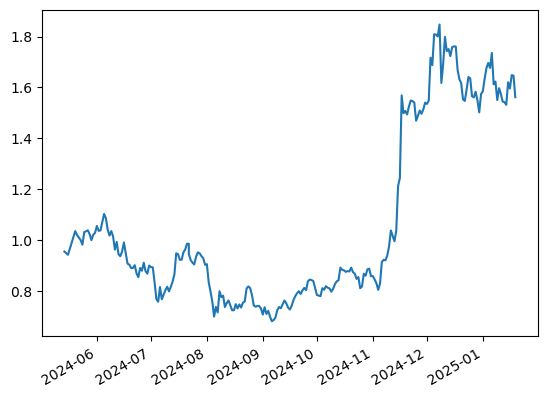

In [38]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [40]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [43]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [44]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3931
XRPUSDT,0.2018
BNBUSDT,0.1863
SUIUSDT,0.0963
PEPEUSDT,0.0668
RAYUSDT,0.0390
AAVEUSDT,0.0168
CRVUSDT,0.0000
IMXUSDT,0.0000
RUNEUSDT,0.0000


In [48]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.364087
BTCUSDT,0.300000
XRPUSDT,0.146851
SUIUSDT,0.077428
BNBUSDT,0.054942
PEPEUSDT,0.030471
RAYUSDT,0.026221


### Current results

In [50]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [51]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.533705
OMUSDT,0.353307
TRXUSDT,0.112989


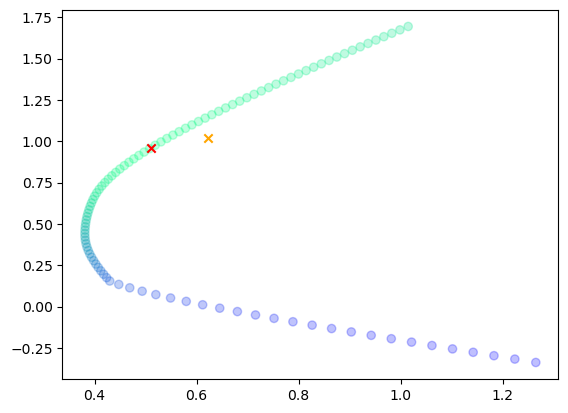

In [52]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [54]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1782.730092,0.451027,0.353307,0.097720
BTCUSDT,956.253141,0.241930,0.533705,-0.291775
SOLUSDT,461.021194,0.116638,0.000000,0.000000
JASMYUSDT,365.749063,0.092534,0.000000,0.000000
ETHUSDT,231.896809,0.058669,0.000000,0.000000
TRXUSDT,116.444665,0.029460,0.112989,-0.083529
BBUSDT,37.321750,0.009442,0.000000,0.000000
BNBUSDT,1.183166,0.000299,0.000000,0.000000
PEPEUSDT,0.000004,0.000000,0.000000,0.000000


In [55]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1782.730092,0.451027,0.364087,0.086940
BTCUSDT,956.253141,0.241930,0.300000,-0.058070
SOLUSDT,461.021194,0.116638,0.000000,0.000000
JASMYUSDT,365.749063,0.092534,0.000000,0.000000
ETHUSDT,231.896809,0.058669,0.000000,0.000000
TRXUSDT,116.444665,0.029460,0.000000,0.000000
BBUSDT,37.321750,0.009442,0.000000,0.000000
BNBUSDT,1.183166,0.000299,0.054942,-0.054643
PEPEUSDT,0.000004,0.000000,0.030471,-0.030471
XRPUSDT,0.000000,0.000000,0.146851,0.000000


# Risk Reward Analysis

In [57]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [58]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

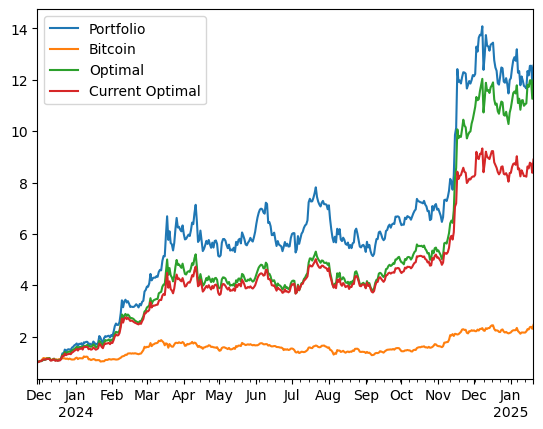

In [59]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [60]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

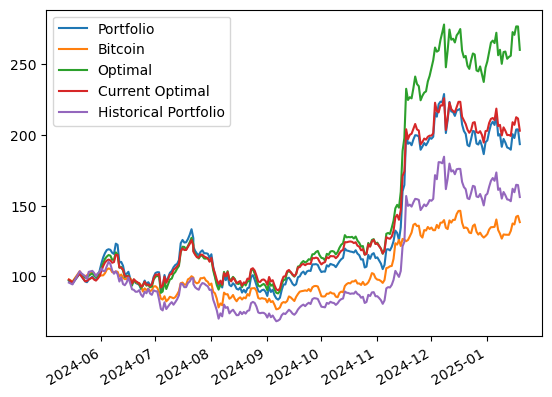

In [61]:
((1+current_perf).cumprod()*100).plot()

In [62]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-01-10,197.302260,129.693358,258.782415,205.478390,159.729385
2025-01-11,194.704963,129.520567,259.151822,203.059980,157.464627
2025-01-12,191.269960,129.445338,254.023724,200.010545,154.493622
2025-01-13,190.697434,129.433070,255.352069,200.099440,154.218040
2025-01-14,189.678849,132.175978,256.176171,199.457223,153.215122
2025-01-15,200.688035,137.457449,272.924735,209.128931,162.042883
2025-01-16,197.953781,136.758041,270.958549,207.270845,159.577157
2025-01-17,203.974093,142.241005,276.926349,212.654133,164.832054
2025-01-18,204.069367,142.893805,276.910530,211.741749,164.645552
2025-01-19,193.615544,138.417370,260.324869,203.118569,156.174667


## Volatilities

In [64]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.615498
 dtype: float64,
 0.6162151539278369)

In [65]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.622781
 dtype: float64,
 0.6227807849142708)

In [66]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.700447
Bitcoin            0.432582
Optimal            0.616215
Current Optimal    0.574680
dtype: float64

In [67]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.44107289619630413

## Risk Contribution

In [69]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.084935,0.054942,0.006915,0.019888,0.001763,0.018126
BTCUSDT,0.436039,0.300000,0.036386,0.138251,0.044352,0.093899
OMUSDT,17.849656,0.364087,0.900401,0.649853,0.533202,0.116651
PEPEUSDT,0.105502,0.030471,0.006722,0.028502,0.003816,0.024685
RAYUSDT,0.134391,0.026221,0.007940,0.026078,0.002462,0.023616
SUIUSDT,0.218763,0.077428,0.014642,0.054274,0.014268,0.040006
XRPUSDT,0.399185,0.146851,0.026993,0.083154,0.026385,0.056769


In [70]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.845521,0.353307,0.544657,0.623805,0.493857,0.129948
BTCUSDT,0.308484,0.533705,0.382627,0.300417,0.185628,0.114790
TRXUSDT,0.047063,0.112989,0.072716,0.075778,0.034751,0.041027


In [71]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.076923,0.45,0.676756,0.665791,0.537472,0.128319
BTCUSDT,0.138721,0.24,0.167855,0.102930,0.025182,0.077748
SOLUSDT,0.047837,0.12,0.074388,0.087247,0.016540,0.070707
JASMYUSDT,-0.011621,0.09,0.034739,0.090823,0.025210,0.065612
ETHUSDT,-0.001366,0.06,0.025988,0.029934,0.002784,0.027150
TRXUSDT,0.012496,0.03,0.018835,0.012694,0.001644,0.011051
BBUSDT,-0.006752,0.01,0.001440,0.010581,0.000412,0.010169


# Value At Risk

## Historical

### Optimal Weights

In [75]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05065815766775472, -0.07427864908453916)

### Current Weights

In [77]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04916234029881232, -0.07169845385325925)

In [78]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [79]:
var=historical_var.iloc[row]
var

OMUSDT      -0.033381
BTCUSDT     -0.002240
SOLUSDT     -0.003692
JASMYUSDT   -0.004998
ETHUSDT     -0.001657
TRXUSDT     -0.000430
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047644
Name: 2024-07-22 00:00:00, dtype: float64

In [80]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.039476
BTCUSDT     -0.008651
SOLUSDT     -0.007976
JASMYUSDT   -0.008863
ETHUSDT     -0.002946
TRXUSDT     -0.001088
BBUSDT      -0.000980
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.069980
dtype: float64

## Parametric

### Optimal Weights

In [83]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06384977345135907, -0.08183775607999065)

### Current Weights

In [85]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06453007812802421, -0.0827097185816495)

## Multivariate

### Optimal Weights

In [88]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.055040562252873286, -0.07063025846525124)

### Current Weights

In [90]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060246711266369525, -0.07899854502271268)

In [91]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.039503
BTCUSDT     -0.005673
SOLUSDT     -0.005273
JASMYUSDT   -0.006489
ETHUSDT     -0.001814
TRXUSDT     -0.001013
BBUSDT      -0.000808
Portfolio   -0.060572
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [95]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05809581022722868, -0.07438444973969063)

### Current Weights

In [97]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060765312613412524, -0.07591404337795757)

In [98]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.040201
BTCUSDT     -0.006566
SOLUSDT     -0.004920
JASMYUSDT   -0.005487
ETHUSDT     -0.001848
TRXUSDT     -0.000715
BBUSDT      -0.000714
Portfolio   -0.060450
dtype: float64

## Student Copula

### Optimal Weights

In [101]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05700128565964775, -0.07334847742160622)

### Current Weights

In [103]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06143378351413595, -0.07945414833551763)

In [104]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.041383
BTCUSDT     -0.005871
SOLUSDT     -0.005883
JASMYUSDT   -0.004952
ETHUSDT     -0.001942
TRXUSDT     -0.000883
BBUSDT      -0.000743
Portfolio   -0.061656
dtype: float64

## Gumbel Copula

### Optimal Weights

In [107]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10413402406612647, -0.14433531252892137)

### Current Weights

In [109]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1077464487360599, -0.1540795958073912)

In [110]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.094384
BTCUSDT     -0.005481
SOLUSDT     -0.001152
JASMYUSDT   -0.004642
ETHUSDT     -0.000038
TRXUSDT     -0.000012
BBUSDT       0.000175
Portfolio   -0.105534
dtype: float64

## Monte Carlo

### Optimal

In [113]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [114]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06688672536748526, -0.08224827964275733)

### Current Weights

In [116]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06618442133411137, -0.0816048434995486)

In [117]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.042433
BTCUSDT     -0.007312
SOLUSDT     -0.005975
JASMYUSDT   -0.006421
ETHUSDT     -0.002170
TRXUSDT     -0.000791
BBUSDT      -0.000777
Portfolio   -0.065878
dtype: float64

## VaR Violation

In [119]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054627,-0.094351,-0.081370,-0.019169
2024-01-15,-0.054627,-0.094377,-0.082388,0.019620
2024-01-16,-0.054627,-0.093851,-0.079417,0.039920
2024-01-17,-0.054627,-0.095388,-0.081657,-0.024129
2024-01-18,-0.054627,-0.098147,-0.082804,-0.039271
...,...,...,...,...
2025-01-16,-0.057690,-0.066514,-0.066734,-0.007204
2025-01-17,-0.054218,-0.062447,-0.060584,0.022025
2025-01-18,-0.054218,-0.061796,-0.058757,-0.000057
2025-01-19,-0.059484,-0.067332,-0.067258,-0.059895


In [120]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034310,-0.083953,-0.080729,-0.016135
2024-05-29,-0.034295,-0.081383,-0.077633,-0.008603
2024-05-30,-0.034295,-0.070310,-0.069481,0.030165
2024-05-31,-0.034295,-0.071094,-0.064228,0.035238
2024-06-01,-0.034295,-0.074062,-0.066759,0.050722
...,...,...,...,...
2025-01-16,-0.065854,-0.075700,-0.074832,-0.013624
2025-01-17,-0.065854,-0.075459,-0.073608,0.030413
2025-01-18,-0.065854,-0.073903,-0.076135,0.000467
2025-01-19,-0.066763,-0.079479,-0.085597,-0.051227


<Axes: >

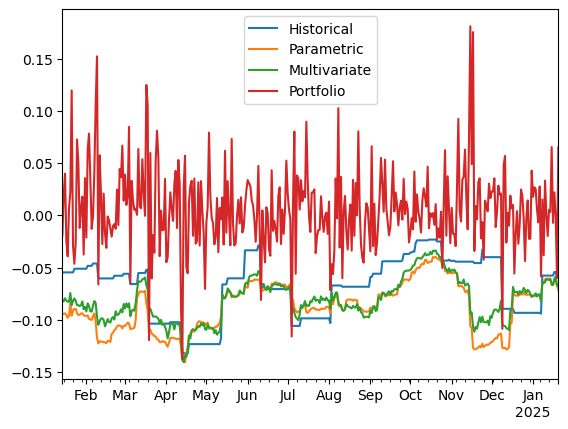

In [121]:
var_data.plot()

<Axes: >

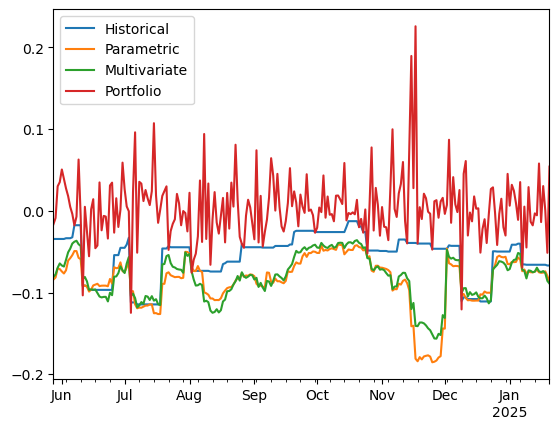

In [122]:
current_var_data.plot()

In [123]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024129,0.010724,0.013405
Kupiec Stat,6.445256,17.581087,14.655108
P-value,0.011125,0.000028,0.000129


In [124]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.067227,0.016807,0.016807
Kupiec Stat,1.348411,7.350916,7.350916
P-value,0.245556,0.006703,0.006703


# Principal Component Analysis

## Historical PCA

In [127]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77943483, 0.07073661, 0.05643089, 0.05149248, 0.04190519])

In [128]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.016059
ADAUSDT      0.016476
ALGOUSDT     0.018740
APTUSDT      0.016720
ARBUSDT      0.017942
ATOMUSDT     0.016451
AVAXUSDT     0.018192
BCHUSDT      0.015277
BNBUSDT      0.008487
BONKUSDT     0.022860
BTCUSDT      0.009583
CRVUSDT      0.019296
DOGEUSDT     0.017550
DOTUSDT      0.017291
ENSUSDT      0.020241
EOSUSDT      0.017312
ETCUSDT      0.015819
ETHUSDT      0.012489
FDUSDUSDT    0.000041
FETUSDT      0.021673
FILUSDT      0.018863
FLOKIUSDT    0.022998
FLOWUSDT     0.018506
GALAUSDT     0.022258
GRTUSDT      0.020820
HBARUSDT     0.018247
ICPUSDT      0.016880
IMXUSDT      0.018931
INJUSDT      0.019356
IOTAUSDT     0.019562
JASMYUSDT    0.019339
LDOUSDT      0.019496
LINKUSDT     0.016221
LTCUSDT      0.012534
MKRUSDT      0.013004
NEARUSDT     0.020703
OMUSDT       0.010724
OPUSDT       0.018566
PEPEUSDT     0.023511
QNTUSDT      0.014394
RAYUSDT      0.018398
RUNEUSDT     0.020242
SANDUSDT     0.020297
SEIUSDT      0.020382
SHIBUSDT     0.017852
SOLUSDT   

<Axes: >

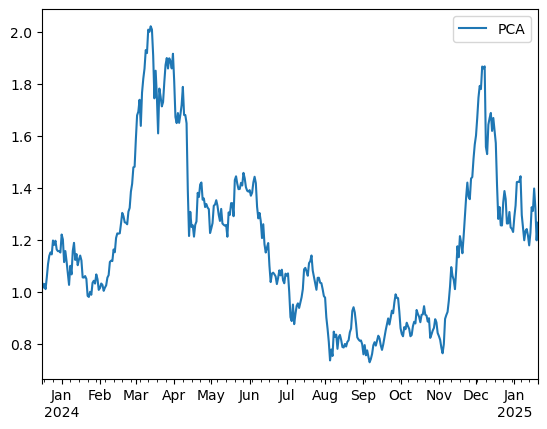

In [129]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

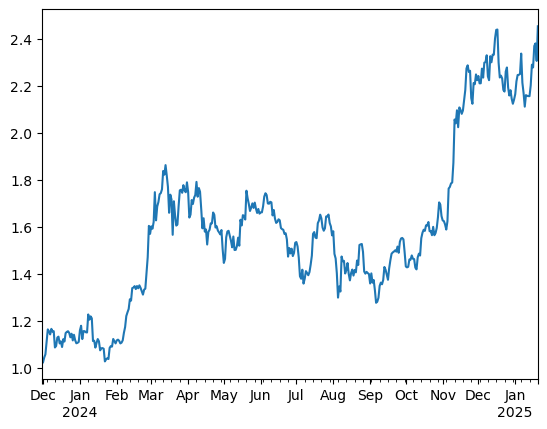

In [130]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [131]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.423187
WBETHUSDT    0.436163
ETHUSDT      0.436628
ETCUSDT      0.452388
               ...   
WLDUSDT      1.142979
BONKUSDT     1.152626
RAYUSDT      1.155290
PEPEUSDT     1.197427
OMUSDT       1.559480
Length: 61, dtype: float64

<Axes: >

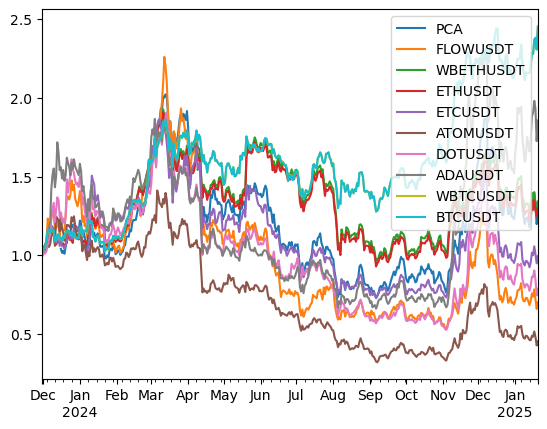

In [132]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

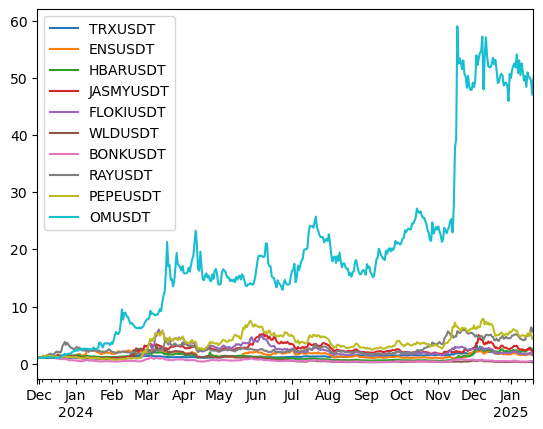

In [133]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [135]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.56118536, 0.14335282, 0.12459487, 0.0993491 , 0.07151785])

In [136]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.092411
BTCUSDT      0.061565
SOLUSDT      0.098676
JASMYUSDT    0.172855
ETHUSDT      0.084863
TRXUSDT      0.055218
BBUSDT       0.209976
BNBUSDT      0.066049
PEPEUSDT     0.158388
Name: PC1, dtype: float64

<Axes: >

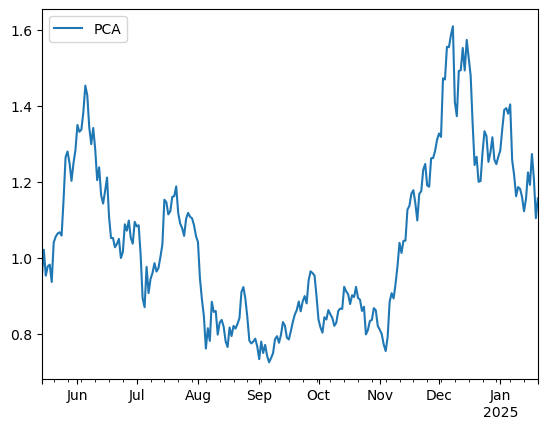

In [137]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

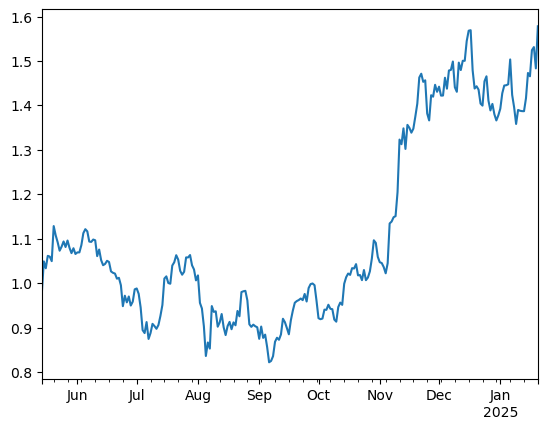

In [138]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [139]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.421345
BNBUSDT      0.447222
BTCUSDT      0.462650
SOLUSDT      0.472865
JASMYUSDT    0.672203
PEPEUSDT     0.730491
BBUSDT       0.761196
TRXUSDT      0.892275
OMUSDT       0.925568
dtype: float64

<Axes: >

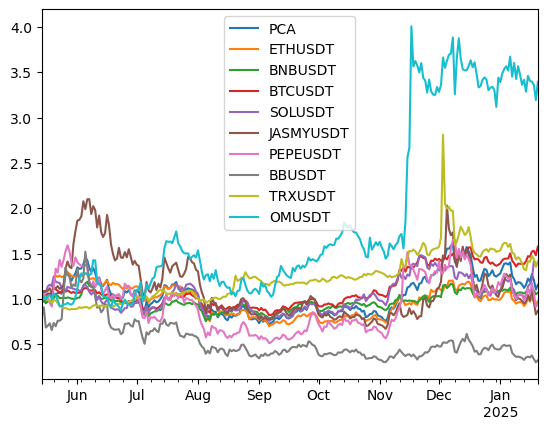

In [140]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [142]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.887631
BBUSDT       1.577358
JASMYUSDT    1.308703
SOLUSDT      1.148928
BTCUSDT      1.000000
ETHUSDT      0.966067
OMUSDT       0.878214
BNBUSDT      0.657109
TRXUSDT      0.320914
Name: BTCUSDT, dtype: float64

In [143]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.037034
BBUSDT       1.878230
PEPEUSDT     1.802047
ETHUSDT      1.119232
TRXUSDT      1.108246
SOLUSDT      1.070720
BTCUSDT      1.000000
OMUSDT       0.936557
BNBUSDT      0.599606
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [145]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [146]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
JASMYUSDT,0.268182
ETHUSDT,0.222304
BNBUSDT,0.188578
SOLUSDT,0.144985
BBUSDT,0.131247
PEPEUSDT,0.090559
BTCUSDT,0.089613
TRXUSDT,0.033085
OMUSDT,-0.027938


### Regression to PCA

In [148]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.2712909374789123

In [149]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.287928
BNBUSDT      1.177820
ETHUSDT      1.022740
PCA          1.000000
SOLUSDT      0.750372
JASMYUSDT    0.439124
PEPEUSDT     0.408709
BBUSDT       0.375392
OMUSDT       0.246923
TRXUSDT      0.240149
dtype: float64

In [150]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      2.437293
BTCUSDT      1.574925
TRXUSDT      1.242747
ETHUSDT      1.218653
PCA          1.000000
OMUSDT       0.801950
BBUSDT       0.747939
PEPEUSDT     0.741929
JASMYUSDT    0.660486
SOLUSDT      0.367168
dtype: float64

### Correlation Matrix

<Axes: >

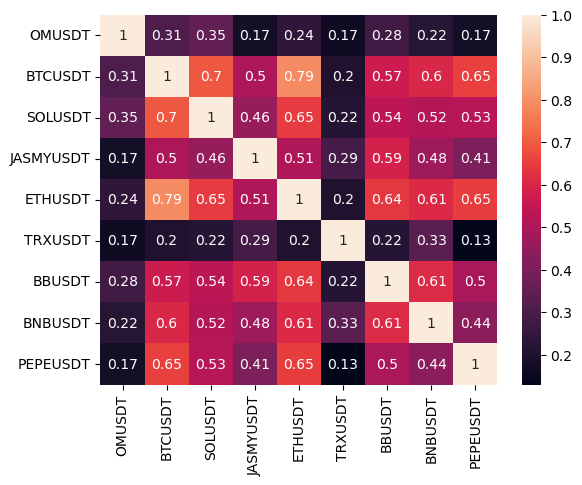

In [152]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

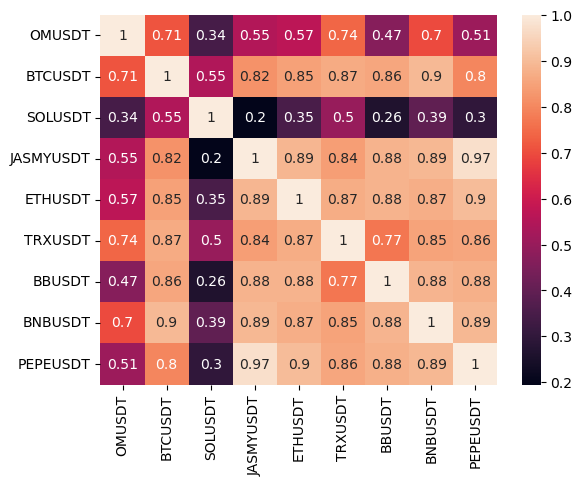

In [153]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [155]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [156]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-06-14,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.173523,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-07-14,0.643348,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.320529,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-08-13,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.578614,0.0
2024-09-12,0.452467,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.273009,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-12,0.003767,0.0,0.0,0.027022,0.0,0.0,0.0,0.0,0.0,0.0,...,0.438301,0.078709,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-11,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-11,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.027718,0.229958,0.0
2025-01-10,0.003767,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-01-20,0.107642,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.030144,0.0
